In [1]:
# %pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
import copy
import time
import math
import statistics
# from dtaidistance import dtw

# Load files

In [22]:
# file_test = '50words_TEST'
# file_train = '50words_TRAIN'

file_test = 'ECG200_TEST'
file_train = 'ECG200_TRAIN'

# Read files
with open(file_test) as f:
    ts_test = f.read().splitlines()
with open(file_train) as f:
    ts_train = f.read().splitlines()


# Train Data
ts_train = [x.split() for x in ts_train]
ts_train = [[float(s) for s in row] for row in ts_train] 
ts_train = np.array(ts_train) # convert to numpy array
train_classes = ts_train[:,0]  # get the classes
train_data = copy.deepcopy(ts_train)
ts_train = np.delete(ts_train, np.s_[:1], axis=1) # remove the first column, which is the class



# Test Data
ts_test = [x.split() for x in ts_test]
ts_test = [[float(s) for s in row] for row in ts_test]
ts_test = np.array(ts_test) # convert to numpy array
test_classes = ts_test[:,0] # get the classes
test_data = copy.deepcopy(ts_test)
ts_test = np.delete(ts_test, np.s_[:1], axis=1) # remove the first column, which is the class
actual_classes = test_classes
# ts_test = pd.Series(ts_test)
# ts_train = pd.Series(ts_train)

In [23]:
def z_normalize(ts):
    label = ts[0]
    z_mean = statistics.mean(ts[1:])
    z_sd = statistics.pstdev(ts[1:])
    res = np.array([(x-z_mean)/z_sd for x in ts])
    res = np.insert(res, 0, label)
    return res

# Normalize the datasets

In [24]:
# mean = statistics.mean(test_data)
normalized_test = np.array([z_normalize(x) for x in test_data])
normalized_train = np.array([z_normalize(x) for x in train_data])

# Let's Warp!! 
# The DTW Implementation, from scratch.
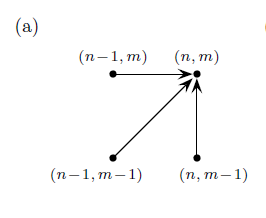

In [25]:
def DTW(s1,s2,window_size,weight):
##     s1 = np.insert(ts1,0,0)
##     s2 = np.insert(ts2,0,0)

    # Initilize variables
    n,m = len(s1) ,len(s2)
    w1,w2,w3 = weight[0],weight[1],weight[2]
    matrix= np.ones((n,m)) * np.inf
    matrix[0][0] = 0        
    for i in range(1,n):
        for j in range(max(1, i-window_size),min(m, i+window_size)):
            cost = (s1[i]-s2[j])**2
#             cost = abs(s1[i]-s2[j])
            matrix[i][j] = min(matrix[i-1][j] + w1*cost,
                               matrix[i-1][j-1] + w2*cost,
                               matrix[i][j-1] + w3*cost)
    distance = matrix[n-1][m-1]
    distance = math.sqrt(distance)
    return distance,matrix

# DTW2, Another step size
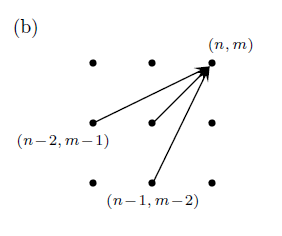

In [26]:
def DTW2(s1,s2,window_size,weight=(1,1,1)):
##     s1 = np.insert(ts1,0,0)
##     s2 = np.insert(ts2,0,0)

    # Initilize variables
    n,m = len(s1) ,len(s2)
    w1,w2,w3 = weight[0],weight[1],weight[2]
    matrix= np.ones((n,m)) * np.inf
    matrix[0][0] = 0
    matrix[1][1] = 1
    for i in range(2,n):
        for j in range(max(2, i-window_size),min(m, i+window_size)):
            cost = (s1[i]-s2[j])**2
            matrix[i][j] = min(matrix[i-1][j-2] + w1*cost,
                               matrix[i-1][j-1] + w2*cost,
                               matrix[i-2][j-1] + w3*cost)
    distance = matrix[n-1][m-1]
    distance = math.sqrt(distance)
    return distance,matrix

# DTW3, Another step size
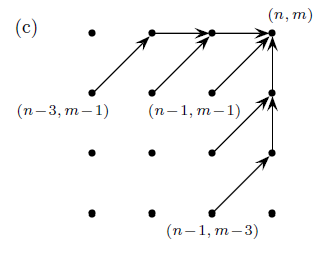

In [27]:
def DTW3(s1,s2,window_size,weight):
##     s1 = np.insert(ts1,0,0)
##     s2 = np.insert(ts2,0,0)

    # Initilize variables
    n,m = len(s1) ,len(s2)
    w1,w2,w3 = weight[0],weight[1],weight[2]
    matrix= np.ones((n,m)) * np.inf
    matrix[0][0] = 0        
    for i in range(1,n):
        for j in range(max(1, i-window_size),min(m, i+window_size)):
            cost = (s1[i]-s2[j])**2
#             cost = abs(s1[i]-s2[j]) * abs(s1[i]-s2[j])
            matrix[i][j] = min(matrix[i-1][j] + w1*cost,
                               matrix[i-1][j-1] + w2*cost,
                               matrix[i][j-1] + w3*cost)
    distance = matrix[n-1][m-1]
    distance = math.sqrt(distance)
    return distance,matrix

# 1NN classification

In [28]:
# def one_NN(train_data,classes,sample,window_size,weight=(1,1,1)):
#     min_dist = np.inf
#     label = -1
#     window_size = int(len(sample)/2)
#     for i in range(len(train_data)):
#         dist,matrix = DTW(train_data[i],sample,window_size)
#         if(dist<min_dist):
#             min_dist = dist
#             label = classes[i]
#     return label

# It is so slow!!  Let's do some Lower bounding
# Lower bound of Keogh

In [29]:
def get_UL(Q,r):
    n = len(Q)
    U = Q.copy()
    L = Q.copy()
    
    # The first element is the 'class(label)'
    # we will loop from r+1 to n-r-1
    for i in range(r+1,n-r):
        U[i] = np.max(Q[i-r:i+r])
        L[i] = np.min(Q[i-r:i+r])

    left_min = np.min(L[1:r+2])
    left_max = np.max(U[1:r+2]) 
    right_min = np.min(L[n-r-1:])
    right_max = np.max(U[n-r-1:]) 

    for i in range(0,r+1):    
        U[i] = left_max
        L[i] = left_min
    for i in range(n-r,n):
        U[i] = right_max
        L[i] = right_min

    ## Plotting the boundaries (optional)
    # plt.plot(Q[1:],label = 'original')
    # plt.plot(U,label = 'U')
    # plt.plot(L,label = 'L')
    # plt.legend()
    # plt.show()
    return U,L

In [30]:
def lower_bound_distance(Q,C,r,U,L):
    dist = 0.0
    for i in range(1,len(C)):
        if(Q[i] > U[i]):
            dist += (Q[i]-U[i])**2
#             dist += (Q[i]-U[i])
        elif(Q[i] < L[i]):
            dist += (Q[i]-L[i])**2
#             dist += (Q[i]-L[i])
    dist = math.sqrt(dist)
    return dist

# 1NN with LB !!!

In [31]:
def one_NN_LB(train_data,train_classes,sample,window_size,weight):
    min_dist = np.inf
    label = -1
    U,L = get_UL(sample,window_size)
    for i in range(len(train_data)):
        LB_dist = lower_bound_distance(train_data[i],sample,window_size,U,L)
#         LB_dist = 0
#         print ('train_data:'+str(i)+'th ,LB dist = '+str(LB_dist))
        if(LB_dist < min_dist):
            dist,matrix = DTW(train_data[i],sample,window_size,weight)
            if(dist<min_dist):
                min_dist = dist
                label = train_classes[i]
#         else:
#             print('Saved by LB, distance = '+ str(LB_dist))
#     print(min_dist)
    return label

In [32]:
def one_NN_LB2(train_data,train_classes,sample,window_size,weight):
    min_dist = np.inf
    label = -1
    U,L = get_UL(sample,window_size)
    for i in range(len(train_data)):
        LB_dist = lower_bound_distance(train_data[i],sample,window_size,U,L)
#         LB_dist = 0
#         print ('train_data:'+str(i)+'th ,LB dist = '+str(LB_dist))
        if(LB_dist < min_dist):
            dist,matrix = DTW2(train_data[i],sample,window_size,weight)
            if(dist<min_dist):
                min_dist = dist
                label = train_classes[i]
#         else:
#             print('Saved by LB, distance = '+ str(LB_dist))
#     print(min_dist)
    return label

# Let's Predict!!

In [33]:
def predict(test_data,train_data,train_classes,actual_classes,weight=(1,1,1)):
    predicted_classes = np.zeros(actual_classes.shape)
    for i in range(len(test_data)) :
        
        sample = test_data[i]
        window_size = int(len(sample)/10)
#         window_size = 10
        predicted_classes[i] = one_NN_LB(train_data,train_classes,sample,window_size,weight)
        print('processing ' + str(i) + 'th row, the (result,actual) is class:(' +str(predicted_classes[i])+','+str(actual_classes[i])+')' )
    return predicted_classes

In [34]:
def predict2(test_data,train_data,train_classes,actual_classes,weight=(1,1,1)):
    predicted_classes = np.zeros(actual_classes.shape)
    for i in range(len(test_data)) :
        
        sample = test_data[i]
        window_size = int(len(sample)/10)
#         window_size = 10
        predicted_classes[i] = one_NN_LB2(train_data,train_classes,sample,window_size,weight)
        print('processing ' + str(i) + 'th row, the (result,actual) is class:(' +str(predicted_classes[i])+','+str(actual_classes[i])+')' )
    return predicted_classes

In [35]:
# i = 55
# actual_classes = test_classes
# predicted_classes = np.zeros(actual_classes.shape)
# start_time = time.time()
# weight = (1,1,1)
# sample = test_data[i]
# window_size = int(len(sample)/4)
# print(one_NN_LB(train_data,train_classes,sample,window_size,weight))
# print('Actually it is '+str(actual_classes[i]))
# print('Used:'+str(time.time() - start_time))

In [ ]:
weight=(1,1,1)
predicted_classes = predict(normalized_test,normalized_train,train_classes,actual_classes,weight)

accuracy_score(predicted_classes,actual_classes)

processing 0th row, the (result,actual) is class:(1.0,1.0)
processing 1th row, the (result,actual) is class:(1.0,1.0)
processing 2th row, the (result,actual) is class:(1.0,1.0)
processing 3th row, the (result,actual) is class:(1.0,1.0)
processing 4th row, the (result,actual) is class:(-1.0,-1.0)


In [99]:
# c = np.array([1,2,3,4,5])
# d = np.array([1,6,3,8,9])
# confusion_matrix(c,d)
accuracy_score(predicted_classes,actual_classes)

0.84931506849315064

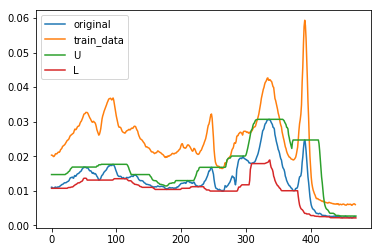

In [337]:
## Plotting the boundaries (optional)
Q = test_data[5]
C = train_data[0]
U,L = get_UL(Q,20)
plt.plot(Q[1:],label = 'original')
plt.plot(C[1:],label = 'train_data')
plt.plot(U,label = 'U')
plt.plot(L,label = 'L')
plt.legend()
plt.show()   

In [ ]:
for x in normalized_test:
    plt.plot(x)
plt.show()

In [297]:
confusion_matrix(predicted_classes,actual_classes)

array([[55,  1,  0, ...,  1,  0,  0],
       [ 0, 41,  1, ...,  0,  0,  2],
       [ 0,  0, 27, ...,  1,  2,  0],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

'Gun_Point_TEST'

In [61]:
# def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
#         """Returns the DTW similarity distance between two 2-D
#         timeseries numpy arrays.

#         Arguments
#         ---------
#         ts_a, ts_b : array of shape [n_samples, n_timepoints]
#             Two arrays containing n_samples of timeseries data
#             whose DTW distance between each sample of A and B
#             will be compared
        
#         d : DistanceMetric object (default = abs(x-y))
#             the distance measure used for A_i - B_j in the
#             DTW dynamic programming function
        
#         Returns
#         -------
#         DTW distance between A and B
#         """

#         # Create cost matrix via broadcasting with large int
#         ts_a, ts_b = np.array(ts_a), np.array(ts_b)
#         M, N = len(ts_a), len(ts_b)
#         cost = sys.maxint * np.ones((M, N))

#         # Initialize the first row and column
#         cost[0, 0] = d(ts_a[0], ts_b[0])
#         for i in xrange(1, M):
#             cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

#         for j in xrange(1, N):
#             cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

#         # Populate rest of cost matrix within window
#         for i in xrange(1, M):
#             for j in xrange(max(1, i - self.max_warping_window),
#                             min(N, i + self.max_warping_window)):
#                 choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
#                 cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

#         # Return DTW distance given window 
#         return cost[-1, -1]

In [62]:
# def _dist_matrix(self, x, y):
#         """Computes the M x N distance matrix between the training
#         dataset and testing dataset (y) using the DTW distance measure
        
#         Arguments
#         ---------
#         x : array of shape [n_samples, n_timepoints]
        
#         y : array of shape [n_samples, n_timepoints]
        
#         Returns
#         -------
#         Distance matrix between each item of x and y with
#             shape [training_n_samples, testing_n_samples]
#         """
        
#         # Compute the distance matrix        
#         dm_count = 0
        
#         # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
#         # when x and y are the same array
#         if(np.array_equal(x, y)):
#             x_s = shape(x)
#             dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
#             p = ProgressBar(shape(dm)[0])
            
#             for i in xrange(0, x_s[0] - 1):
#                 for j in xrange(i + 1, x_s[0]):
#                     dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
#                                                       y[j, ::self.subsample_step])
                    
#                     dm_count += 1
#                     p.animate(dm_count)
            
#             # Convert to squareform
#             dm = squareform(dm)
#             return dm
        
#         # Compute full distance matrix of dtw distnces between x and y
#         else:
#             x_s = np.shape(x)
#             y_s = np.shape(y)
#             dm = np.zeros((x_s[0], y_s[0])) 
#             dm_size = x_s[0]*y_s[0]
            
#             p = ProgressBar(dm_size)
        
#             for i in xrange(0, x_s[0]):
#                 for j in xrange(0, y_s[0]):
#                     dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
#                                                   y[j, ::self.subsample_step])
#                     # Update progress bar
#                     dm_count += 1
#                     p.animate(dm_count)
        
#             return dm

In [63]:
# def predict(self, x):
#         """Predict the class labels or probability estimates for 
#         the provided data

#         Arguments
#         ---------
#           x : array of shape [n_samples, n_timepoints]
#               Array containing the testing data set to be classified
          
#         Returns
#         -------
#           2 arrays representing:
#               (1) the predicted class labels 
#               (2) the knn label count probability
#         """
        
#         dm = self._dist_matrix(x, self.x)

#         # Identify the k nearest neighbors
#         knn_idx = dm.argsort()[:, :self.n_neighbors]

#         # Identify k nearest labels
#         knn_labels = self.l[knn_idx]
        
#         # Model Label
#         mode_data = mode(knn_labels, axis=1)
#         mode_label = mode_data[0]
#         mode_proba = mode_data[1]/self.n_neighbors

#         return mode_label.ravel(), mode_proba.ravel()

In [64]:
# a = np.array([1,2,3])
# b = np.array([2,3,4,5])

In [65]:
# 0.13358939348611112
# x

In [ ]:
 to 